In [1]:
import warnings
warnings.filterwarnings('ignore')

# Categorical Dot Maps

[Jeff Allen](http://jamaps.github.io)

April, 2023

Dot maps are super useful for mapping demographic categories.

Check out the map below. Each dot on the map represents 10 households in the City of Toronto, each are colored by their housing tenure - whether they rent or own, and if so, whether they live in subsidized housing or have a mortgage.

The benefit of dot maps like this, compared to areal choropleth maps, is that they can show both relative density (i.e., a greater concentration of households in one area compared to another) as well as relative proportions (e.g., more households renting than owning their home in one part of the city compared to another).

These maps also display well at multiple scales. We can examine general patterns across the entire city or zoom in on an area to identify local patterns.

<img src="images/toronto-housing-dot-map.png" width="1001">

Dot maps showing demographic and household data, like the one above, are often based on census data. Census data are usually publicly available and pre-aggregated to neighbourhoods and other boundary areas. In Canada, for instance, maps are often created using neighbourhood Census Tracts or smaller Dissemination Area boundaries.

The dots on demographic dot maps, like those shown above, are therefore not perfect representations of where people live; they are estimated. For example, in the map above, if we know that there are 100 households in subsidized housing in a neighbourhood, we generate 10 dots randomly placed within that neighbourhood. If we have available data, this process can be improved by via [dasymetric](https://en.wikipedia.org/wiki/Dasymetric_map) mapping,  where we only place dots in locations where we think people live. For example, in the above map, we used a land-use layer to place dots only in residential zones rather than parks or industrial zones. Once we have this working for one neighbourhood, it is then repeated for all neighbourhoods and all categories we want to include on our map.

In this tutorial, we're going to cover how to create dot maps like these using [Python](https://www.python.org/), mostly using [geoPandas](https://geopandas.org/), with some final cartography in [QGIS](https://www.qgis.org/en/site/) and [Inkscape](https://inkscape.org/). The example data will be to replicate the map above, but the methods and code can be applied to anywhere with similar data.

## Prerequisites

Prior knowledge of pandas, geopandas, QGIS, and Inkscape (or similar graphic design software) would be helpful for the following tutorial.

Click [here](https://github.com/schoolofcities/mapping-workshops-2023/raw/main/notebooks/categorical-dot-maps/categorical-dot-maps.zip) to download this article as a Jupyter Notebook alongside the datasets required. In the download, there is also a standalone Python script, if you want to run the steps all-at-once or integrate with anything else you have brewing.

You can also run the notebook [Binder](https://mybinder.org/v2/gh/schoolofcities/mapping-workshops-2023/HEAD?urlpath=lab%2Ftree%2Fnotebooks%2Fcategorical-dot-maps%2Fcategorical-dot-maps.ipynb)

If you are running the notebook and/or script locally (generally recommended), you will need to use the following libraries. You'll have to install them (e.g. via `pip` or `conda`) if you do not have them installed already.

In [2]:
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

## Loading Data

We're going to replicate the map of Toronto shown at the top of this page. I've pre-filtered the source datasets for Toronto, and they are included in the download link above. The datasets we'll be using are:
- [Census Dissemination Areas (DA) Polygons](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index-eng.cfm)
- [Census Data on Housing Tenure](https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/index.cfm?Lang=E)
- [Toronto Land Use Spatial Data](https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/1VMJAG)

Also included are layers solely for cartographic purposes (i.e. as reference layers on the final map)
- [Toronto Boundary Polygon from OpenStreetMap](https://www.openstreetmap.org/relation/324211)
- [Lake Ontario Polygon from OpenStreetMap](https://www.openstreetmap.org/relation/1206310)
- [Major Trasnit Lines & Stops from Metrolinx](https://www.metrolinx.com/en/about-us/open-data)

To get started, let's load the census data:

In [3]:
da = gpd.read_file("data/toronto-da-2021.geojson")
dft = pd.read_csv("data/toronto-tenure-da-2021.csv")
dft.fillna(0, inplace=True)

The GeoDataFrame, called `da`, represents the spatial boundaries of each Dissemination Area (DA). The `dft` DataFrame contains a table of the number of households in each DA that either rent or own their home. We can join these two based on their unique identifier, `DAUID`. 

In [4]:
dft["DAUID"] = dft["DAUID"].astype('str')
da = da.merge(dft, how='left', on='DAUID')
da.head(5)

,DAUID,DGUID,LANDAREA,PRUID,geometry,Owner,Renter,Owner_with_mortgage,Renter_in_subsidized_housing
0,35200002,2021S051235200002,0.0504,35,"MULTIPOLYGON (((-79.20270 43.82367, -79.20228 ...",95.0,10.0,50,0
1,35200003,2021S051235200003,0.0468,35,"MULTIPOLYGON (((-79.20080 43.81978, -79.20129 ...",70.0,15.0,51,0
2,35200004,2021S051235200004,0.0488,35,"MULTIPOLYGON (((-79.20522 43.81890, -79.20524 ...",100.0,0.0,57,0
3,35200005,2021S051235200005,0.0443,35,"MULTIPOLYGON (((-79.20414 43.81748, -79.20447 ...",90.0,15.0,50,0
4,35200006,2021S051235200006,0.0572,35,"MULTIPOLYGON (((-79.19962 43.81726, -79.20026 ...",120.0,15.0,72,0


## Initial Exploration

Let's calculate a column containing the total number of households in each DA. Then create two additional columns: one for households that own their home without a mortgage, and another for those that rent their home without living in subsidized housing.

In [5]:
da["Total"] = da["Owner"] + da["Renter"]
da["Owner_no_mortgage"] = da["Owner"] - da["Owner_with_mortgage"]
da["Renter_not_in_subsidized_housing"] = da["Renter"] - da["Renter_in_subsidized_housing"]

We now have four categories that add up to the total number of households in a DA
- Owners with a mortgage
- Owners without a mortgage
- Renters in subsidized housing
- Renters not in subsidized housing

Let's make a choropleth map of the percent of each using the same classification scheme to explore and compare. We're also plotting in yellow DAs that have a Total = 0 (i.e. those that return a null when dividing by 0).

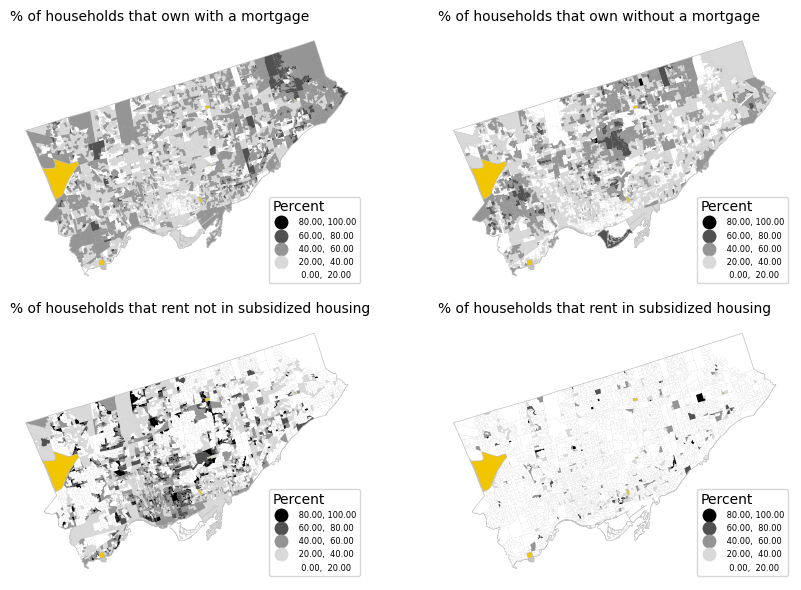

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,6))

variables = [
    "Owner_with_mortgage", 
    "Owner_no_mortgage", 
    "Renter_not_in_subsidized_housing", 
    "Renter_in_subsidized_housing"
]
titles = [
    "% of households that own with a mortgage", 
    "% of households that own without a mortgage", 
    "% of households that rent not in subsidized housing", 
    "% of households that rent in subsidized housing"
]

for i, v in enumerate(variables):
    # background border and color (to highlight 'no data' values)
    da.plot(
        edgecolor = "#c2c2c2",
        color = "#F1C500",
        linewidth = 1,
        ax = ax[int(i / 2), i % 2]
    );
    # DA layer shaded by percent of households for each category
    da.plot(
        column = 100 * da[v] / da["Total"], 
        cmap = 'Greys', 
        legend = True,
        ax=ax[int(i / 2), i % 2],
        scheme='user_defined',
        classification_kwds=dict(bins=[20, 40, 60, 80, 100]),
        legend_kwds = {
            "loc": "lower right",
            "fontsize": 6,
            "title": "Percent",
            "alignment": "left",
            "reverse": True
        }
    ).set_axis_off()
    # sub-plot titles
    ax[int(i / 2), i % 2].set_title(
        titles[i], 
        fontsize=10, 
        loc='left'
    )
plt.tight_layout()

From the choropleth maps, we can already identify some patterns. Renting is more common in downtown areas and some suburban nodes, while subsidized renting is highly concentrated in a few Dissemination Areas. Owning, on the other hand, is more evenly distributed, but those who own their homes without a mortgage tend to live in more central locations.

These choropleth maps are a good start, but they have some limitations:
- They only show the percent (i.e. rate) of each tenure type, not the density. Areas of the same value on the maps above may have very different concentrations of dwellings. 
- In order to look at all four variables, we needed to make 4 separate plots. These are useful for overall comparisons, but it's difficult to compare specific neighbourhoods.
- The concentration of dwellings probably varies across each DA polygon. Some of these DAs are quite large, but mostly consist of non-residential land (e.g. parks, industrial, etc.), so shading the entire DA can be a bit misleading in terms of *where* households are.
- A few of the DAs have 0 population. We coloured these as an extra category to our map (yellow), but this can distract a bit from the overall story.

## Categorical Dot Maps

One solution to the above-noted issues are categorical dot maps. These maps can show the relative proportions and densities among one or more categories.

The first step in creating a dot map like the above is to decide on a rate of households per dot, and then calculate the number of dots to generate per area based on this rate and the number of households in the area. For example, if there are 200 households in a DA, and the rate is 10 households per dot, then we would generate 20 dots in the DA.

We can do this pretty simply as shown below, using the variable `d` to represent the rate of households per dot.

Note that it can be difficult to initially judge what this rate, `d`, should be. This may vary depending on the intended size of your map as well as the spatial distribution of what you're trying to map. Deciding on a dot rate often requires some iteration in generating the dots, looking at the output on a map, and then re-generating them if need be. (I initially started with `d = 20`, but decided to reduce since I thought the map was too sparse).

In [7]:
d = 10
da["Owner_with_mortgage_dots"] = da["Owner_with_mortgage"] / d
da["Owner_no_mortgage_dots"] = da["Owner_no_mortgage"] / d
da["Renter_in_subsidized_housing_dots"] = da["Renter_in_subsidized_housing"] / d
da["Renter_not_in_subsidized_housing_dots"] = da["Renter_not_in_subsidized_housing"] / d

The second step is generating dots that we can plot on a map. For each DA, we generate X random dots, based on the numbers calculate above. Below is a schematic example.

The simplest approach is on the left, placing dots randomly throughout the DA polygon..

One the right is a [dasymetric](https://en.wikipedia.org/wiki/Dasymetric_map) (dasy = dense, metric = measure) approach, where we use another dataset, such as land-use data, to clip out non-residential areas prior to generating dots. For example, on the right, we're only placing dots in the areas that are not retail or parks. This provides better estimation that the dots are located where households actually live.

<img src="images/dot-generation.svg" width="800">

Let's try to dasymetrically generate dots for every DA in Toronto!

For Toronto, we fortunately have a dataset on land-use that we can use to classify areas as "residential" (i.e. candidate areas for placing dots), and "non-residential". Let's load and quickly plot the data:

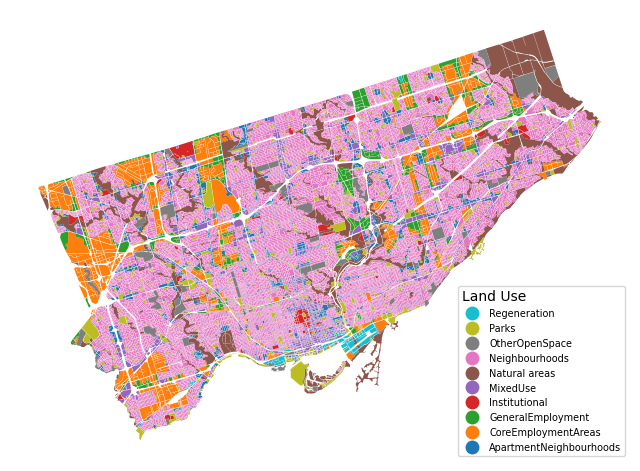

In [8]:
lu = gpd.read_file("data/toronto-land-use-2022-sp.shp")

fig, ax = plt.subplots(figsize=(8,7))

lu.plot(
    column = "Class_name", 
    categorical = True,
    legend = True,
    edgecolor = None,
    ax=ax,
    legend_kwds = {
        "loc": "lower right",
        "fontsize": 7,
        "title": "Land Use",
        "alignment": "left",
        "reverse": True
    }
).set_axis_off();

Residential are classified as `["MixedUse", "Neighbourhoods", "ApartmentNeighbourhoods"]`. Let's query out these layers and save to a new GeoDataFrame.

In [9]:
res_classes = ["MixedUse", "Neighbourhoods", "ApartmentNeighbourhoods"]
res = lu[lu['Class_name'].isin(res_classes)]

Now let's cut out the non-residenital zones from the Dissemination Area polygons. We can think of this operation like a cookie cutter.

This is a two-step process in `geopandas`. First we use the [overlay](https://geopandas.org/en/stable/docs/user_guide/set_operations.html) function to select out only . 

At the end, we dissolve the geometries (i.e. a spatial group-by) by the `DAUID` since the instresection can lead to several different features with the same `DAUID`. This happens when two non-touching residential zones spatially overlap with a single Dissemination Area.

In [10]:
gdf = gpd.overlay(da, res, how='intersection').dissolve(by = "DAUID")

Here's the result for a few DAs. The clipped residential area in yellow, overlaid by the original DA geometries.

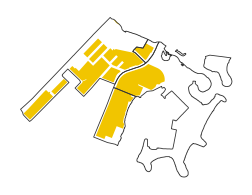

In [33]:
fig, ax = plt.subplots(figsize=(3, 3))

gdf.tail(4).plot(
    color = "#F1C500",
    linewidth = 0,
    ax = ax
)
da.tail(4).plot(
    facecolor = 'none',
    linewidth = 0.6,
    edgecolor = "#343434",
    ax = ax
).set_axis_off()

Now let's generate some dots! Here's a function that takes an input geometry and returns a random point inside of it. Specifically, this function generates a random point within the bounding box of the polygon, checks if it's contained by the polygon, if so, returns it, but if not, continues to generate points until this condition is met.

In [12]:
def gen_dot(polygon):
    while True:
        pt = Point(random.uniform(polygon.bounds[0], polygon.bounds[2]), random.uniform(polygon.bounds[1], polygon.bounds[3]))
        if (polygon.contains(pt)==True):
            points = [pt.x,pt.y]
            break
    return points

Let's apply this to loop over our clipped DA dataset, generating all of our dots! This might take a few seconds, not super long though, for me it took less than a minute.

At the end of this cell, we're also saving the dots as a `.geojson` file so we can load it later, either in this same notebook or elsewhere (e.g. in QGIS).

In [34]:
%%time

variables = [
    "Owner_with_mortgage", 
    "Owner_no_mortgage", 
    "Renter_not_in_subsidized_housing", 
    "Renter_in_subsidized_housing"
]

output = []

for index, row in gdf.iterrows():
    for var in variables:
        n = round(row[var + "_dots"])
        i = 0
        while i < n:
            dot = gen_dot(row["geometry"])
            output.append([var,dot[0],dot[1]])
            i += 1
            
# converting the output to a geodataframe
dots = pd.DataFrame(output, columns = ["type","x","y"])
geometry = [Point(xy) for xy in zip(dots['x'], dots['y'])]
dots = gpd.GeoDataFrame(dots, geometry=geometry)
dots = dots[["type","geometry"]].set_crs('epsg:4326')
dots.to_file("data/dots.geojson", driver="GeoJSON")

CPU times: user 46.3 s, sys: 55.6 ms, total: 46.4 s
Wall time: 46.5 s


Great! Now let's plot these dots on a map to see if it worked properly!

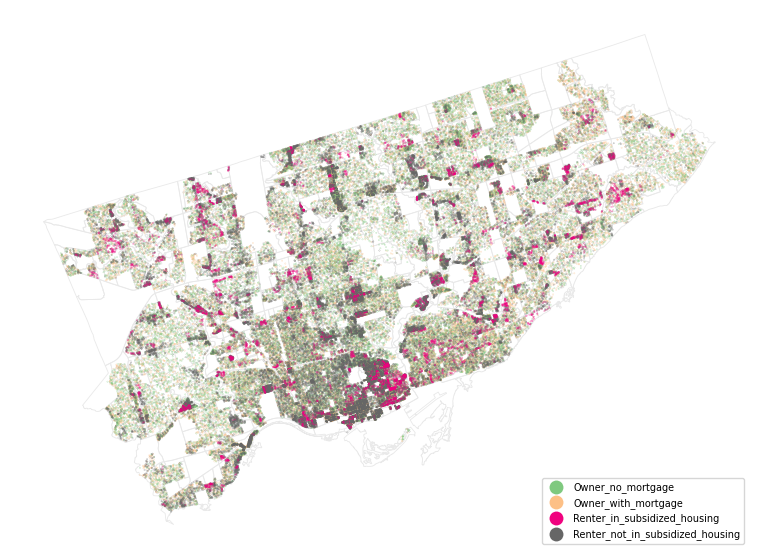

In [14]:
fig, ax = plt.subplots(figsize=(10,7))

# background DA polygon layer
da.plot(
    facecolor = 'none',
    linewidth = 0.6,
    edgecolor = "#e9e9e9",
    ax = ax
)

# dot layer coloured by each category
dots.plot(
    ax = ax,
    column='type',
    categorical=True, 
    legend=True,
    cmap = 'Accent',
    markersize = 0.02,
    legend_kwds = {
        "loc": "lower right",
        "fontsize": 7,
        "alignment": "left"
    }
).set_axis_off()

## Cartographic Details

Okay! So the above worked pretty well, but the map isn't great, and could use some additional context and layout items.

From here, let's pivot over to trying to make the map prettier and more useful in QGIS and Inkscape. 

(Note that we could probably do most of the following in Python, but my personal preference is to tweak the symbology of layers via a GUI rather than just code).

My workflow for designing 'static' maps with larger datasets is to ... 
1) visualize the data layers in QGIS
2) export it as a high-resolution raster image `.png` (we could export it as a vector `.svg`, but would like result in a large file size difficult to load in Inkscape)
3) open this `.png` in Inkscape, and add additional layout items (e.g. title, legend, north arrow, etc.)

Below is a screenshot of the dot layer, as well as the other reference layers, loaded into QGIS. The QGIS project file `.qgis` is in the download zip at `toronto-housing-dot-map.qgz`. In QGIS, I loaded the layers and then made some tweaks to try to improve the maps legibility and aesthetics.
- I've overlaid major transit routes (TTC) for general reference and orientation.
- I've added a boundary polygon for the City of Toronto to better distinguish the study area.
- The dots are colours are specifically chosen for their contrast.
- There are several 'background' layers added to the map (land use, DA boundaries, Lake Ontario). These provide some geographic reference, but the colours are chosen to be more nuanced and not distract from the main layer of interest (the dots).
- I've rotated the map ~17 degrees. This creates a better "fit" of the geography onto the rectangular page by omitting empty "white" space.

<img src="images/qgis-screenshot.png" width="600">

epxe we like what we have, we can export it and open it in Inkscape to add a few layout items. It's important to export the map in exactly the same dimensions that we want it to be in our final layout (i.e. so we aren't resizing it in Inkscape which can cause distortion or resolution change). 

For this map, I exported it at 10 inches wide by 6 inches tall. This would fit nicely on a landscape-oriented letter page with a margin, but also view well online on most screens.

Below is a screenshot of the map in Inkscape, with each of the layout items selected. Rotating the map 17 degrees has allowed for more efficient use of space. The legend fits nicely in the bottom right corner and there is little white space elsewhere.

<img src="images/inkscape-screenshot.png" width="600">

As part of the legend, I also wanted to include a mini-chart showing the distribution of each of the four tenure-types shown on the map. 

I wanted relatively unique labelling on this chart, showing the percent of rent and own on one side, and the sub-categories on the other. This is a simple chart, but with very specific labelling, so I decided to create this "by hand", drawing the boxes and labels myself. To get the percents, I quickly plopped out the block of code below, and then drew the rectangles to be in proportion to each number.

In [15]:
for v in variables:
    print(v, da[v].sum(), 100 * da[v].sum() / da["Total"].sum())

Owner_with_mortgage 339776 29.282451695192787
Owner_no_mortgage 262904.0 22.65749694055191
Renter_not_in_subsidized_housing 484509.0 41.75577847872175
Renter_in_subsidized_housing 73151 6.304272885533551


Here's the final map! exported at 300dpi.

<img src="images/toronto-housing-dot-map.png" width="1001">

## Caveats



Of course dot maps aren't always the best option. They can be a bit difficult to parse out colours and patterns, especially once we add more and more categories. If you want to dig into the patterns of each specifically, i.e. are less concerned about the comparisons, or are only interested in density OR proportions (rather than both at the same time), a series of individual choropleth or single-category dot density maps would be good to pursue as well. It's rare to have too many maps :)

## Additional Resources

- [Wikipedia page on dot maps](https://en.wikipedia.org/wiki/Dot_distribution_map)
- [Wikipedia page on dasymetric mapping](https://en.wikipedia.org/wiki/Dasymetric_map)